<a href="https://colab.research.google.com/github/francoishcm/BackTesting/blob/master/Zipline_Reloaded_BacktestEngine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%%bash
wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
tar -xzf ta-lib-0.4.0-src.tar.gz
cd ta-lib/
./configure
make
make install

checking for a BSD-compatible install... /usr/bin/install -c
checking whether build environment is sane... yes
checking for a thread-safe mkdir -p... /bin/mkdir -p
checking for gawk... no
checking for mawk... mawk
checking whether make sets $(MAKE)... yes
checking for gcc... gcc
checking for C compiler default output file name... a.out
checking whether the C compiler works... yes
checking whether we are cross compiling... no
checking for suffix of executables... 
checking for suffix of object files... o
checking whether we are using the GNU C compiler... yes
checking whether gcc accepts -g... yes
checking for gcc option to accept ISO C89... none needed
checking for style of include used by make... GNU
checking dependency style of gcc... gcc3
checking build system type... x86_64-unknown-linux-gnu
checking host system type... x86_64-unknown-linux-gnu
checking for a sed that does not truncate output... /bin/sed
checking for grep that handles long lines and -e... /bin/grep
checking for egr

--2022-02-03 20:21:29--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 204.68.111.105
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|204.68.111.105|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2022-02-03 20:21:29--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 204.68.111.105
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent, awaiting response... 302 Found
Location: http://phoenixnap.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2022-02-03 20:21:29--  http://phoenixnap.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving phoenixna

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%pip install zipline-reloaded

     |████████████████████████████████| 6.2 MB 25.2 MB/s 
     |████████████████████████████████| 85 kB 4.3 MB/s 
     |████████████████████████████████| 108 kB 46.5 MB/s 
     |████████████████████████████████| 4.7 MB 45.5 MB/s 
     |████████████████████████████████| 129 kB 52.9 MB/s 
     |████████████████████████████████| 210 kB 57.9 MB/s 
     |████████████████████████████████| 269 kB 48.7 MB/s 
     |████████████████████████████████| 75 kB 4.0 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 
     |████████████████████████████████| 6.4 MB 47.7 MB/s 
  Created wheel for exchange-calendars: filename=exchange_calendars-3.3-py3-none-any.whl size=164232 sha256=7877d5aef228e7a1f2e0a7879d5c37944b5ab2a6955f6404cfe9bc2e59e3ebee
  Stored in directory: /root/.cache/pip/wheels/37/39/46/7f1bb676a570d898a7a6ee7a25d9f239134465db32e09647d5
  Created wheel for logbook: filename=Logbook-1.5.3-cp37-cp37m-linux_x86_64.whl size=66400 sha256=0d09e625c39aa07a86ea3495ae3f84294d27bda8e6239eda

In [5]:
!pip install matplotlib

In [6]:
!pip install quandl

In [21]:
!QUANDL_API_KEY=KUnssHvVERHb5XYu9C1- zipline ingest -b 'quandl'

[2022-02-04 00:04:28.150179] INFO: zipline.data.bundles.core: Ingesting quandl.
[2022-02-04 00:04:28.150436] INFO: zipline.data.bundles.quandl: Downloading WIKI metadata.
[2022-02-04 00:04:39.938468] INFO: zipline.data.bundles.quandl: Parsing raw data.
[2022-02-04 00:05:14.220664] INFO: zipline.data.bundles.quandl: Generating asset metadata.
Merging daily equity files:  [------------#-----------------------]  1731/usr/local/lib/python3.7/dist-packages/zipline/data/bcolz_daily_bars.py:366: UserWarning: Ignoring 1 values because they are out of bounds for uint32:             open  ...  split_ratio
2011-04-11  1.79  ...          1.0

[1 rows x 7 columns]
  winsorise_uint32(raw_data, invalid_data_behavior, "volume", *OHLC)
Merging daily equity files:  [####################################]      
[2022-02-04 00:07:48.041168] INFO: zipline.data.bundles.quandl: Parsing split data.
[2022-02-04 00:07:48.279440] INFO: zipline.data.bundles.quandl: Parsing dividend data.
[2022-02-04 00:07:50.05742

In [18]:
!zipline bundles

csvdir <no ingestions>
custom-csvdir-bundle 2022-02-03 22:29:40.218255
custom-csvdir-bundle 2022-02-03 22:27:19.377542
custom-csvdir-bundle 2022-02-03 22:23:31.204498
quandl 2022-02-03 21:48:55.302122
quandl 2022-02-03 20:54:09.018163
quantopian-quandl <no ingestions>


In [8]:
!pip install git+https://github.com/quantopian/pyfolio


  Cloning https://github.com/quantopian/pyfolio to /tmp/pip-req-build-5_gzgk_t
  Running command git clone -q https://github.com/quantopian/pyfolio /tmp/pip-req-build-5_gzgk_t
     |████████████████████████████████| 52 kB 1.2 MB/s 
  Created wheel for pyfolio: filename=pyfolio-0.9.2+75.g4b901f6-py3-none-any.whl size=75774 sha256=7420500b202342b5f625010a3a031be85cc973279c5e9b370e2e707870be38da
  Stored in directory: /tmp/pip-ephem-wheel-cache-7q7elk1o/wheels/2d/aa/24/c99ed55ef37c69e33815248c1622cdb81b65ec753868004c28
  Created wheel for empyrical: filename=empyrical-0.5.5-py3-none-any.whl size=39780 sha256=c354582183202f288731d2747d7f0cc2928455843740c1abcedc32e25eb72e9b
  Stored in directory: /root/.cache/pip/wheels/d9/91/4b/654fcff57477efcf149eaca236da2fce991526cbab431bf312
Successfully built pyfolio empyrical


Start date,1996-01-02
End date,2018-12-31
Total months,275
,Backtest
Annual return,9.333%
Cumulative returns,676.96%
Annual volatility,22.111%
Sharpe ratio,0.51
Calmar ratio,0.14
Stability,0.14
Max drawdown,-65.384%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,65.38,1999-12-27,2011-12-08,NaT,NaN
1,22.68,1998-07-17,1998-10-08,1998-11-25,94
2,19.69,1999-04-05,1999-05-25,1999-07-16,75
3,19.04,1997-07-17,1998-01-09,1998-02-23,158
4,17.79,1999-07-16,1999-08-12,1999-12-15,109


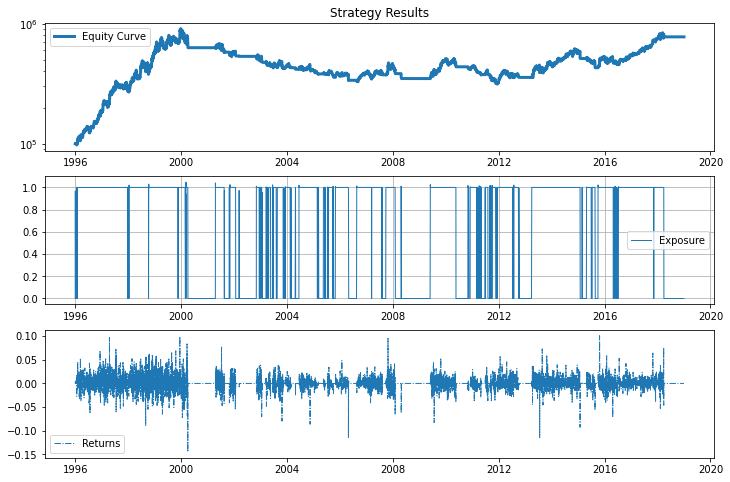

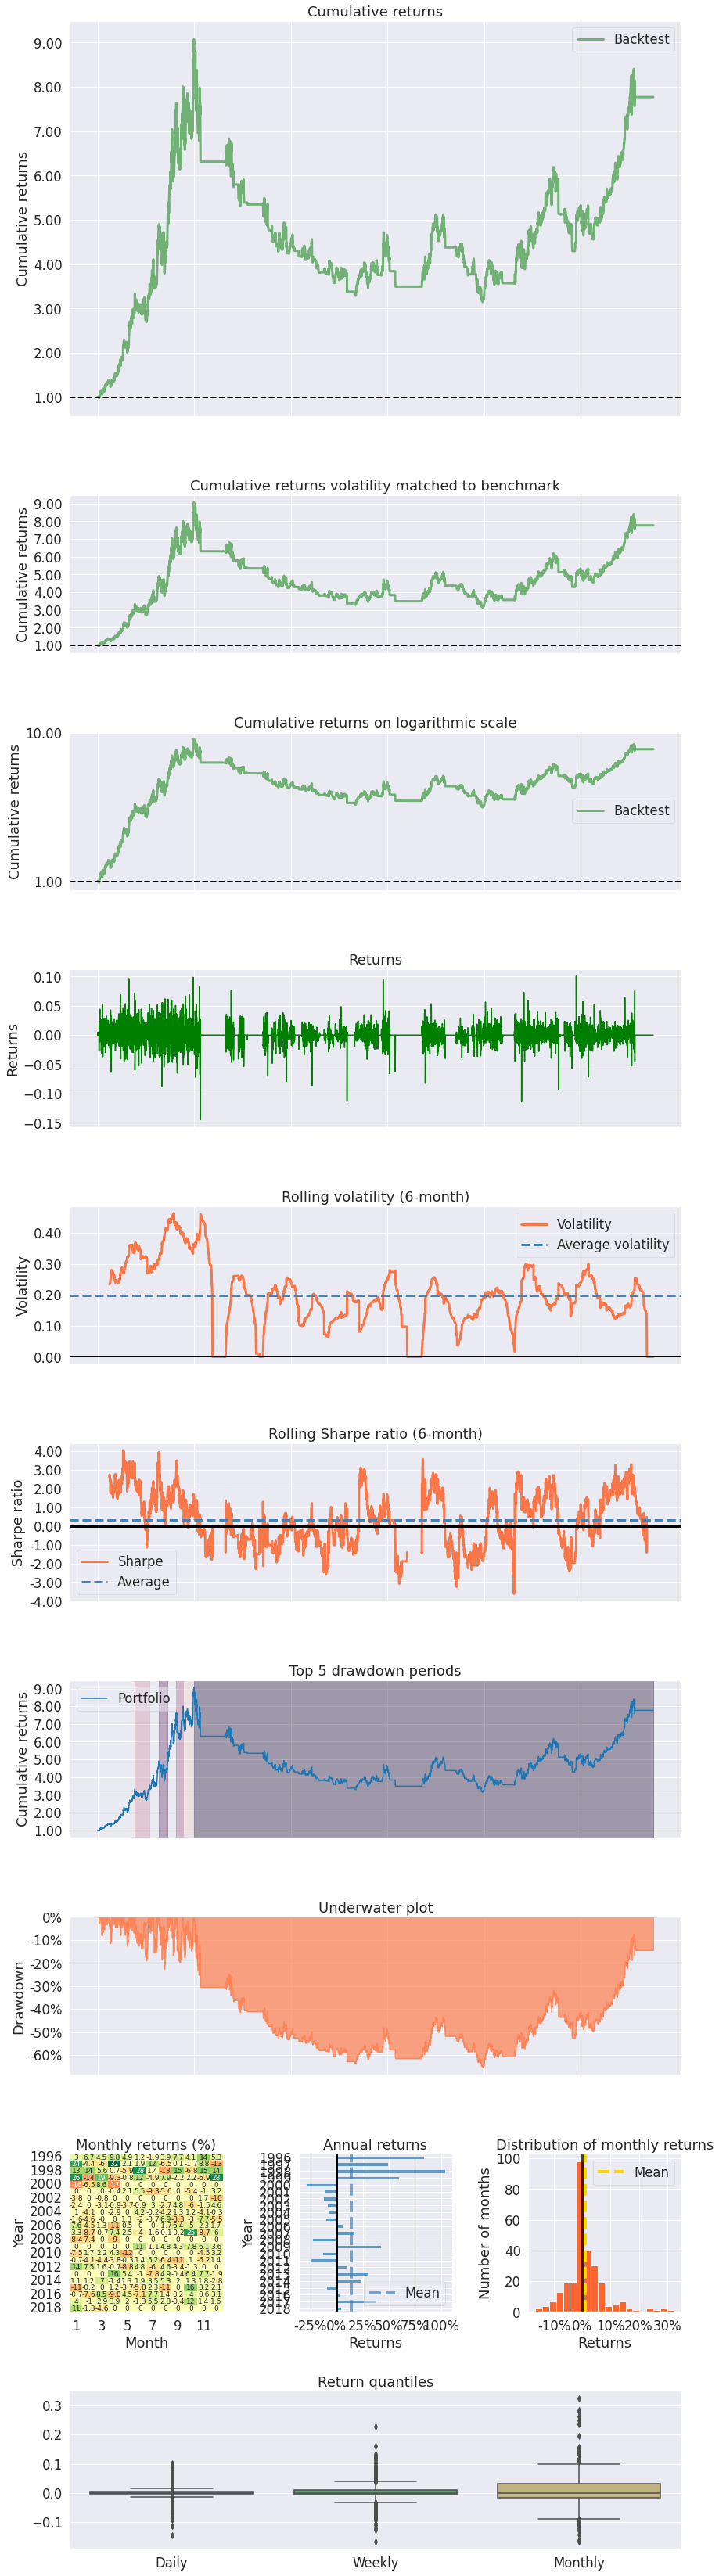

In [11]:
%matplotlib inline
from zipline import run_algorithm
from zipline.api import order_target_percent, symbol
import pyfolio as pf
from datetime import datetime
import pytz
import pandas as pd


def initialize(context):
  context.stock = symbol ('MSFT')
  context.index_average_window = 200

def handle_data(context, data):
  equities_hist = data.history(context.stock, "close",
                               context.index_average_window, "1d")
  
  if equities_hist[-1] > equities_hist.mean():
    order_target_percent(context.stock,1)
  else:
    order_target_percent(context.stock,0)

def analyze(context, perf):
  
  fig = plt.figure(figsize=(12, 8))

  # First chart
  ax = fig.add_subplot(311) 
  ax.set_title('Strategy Results')
  ax.semilogy(perf['portfolio_value'], linestyle='-', label='Equity Curve', linewidth=3.0)
  ax.legend()

  ax.grid(False)
  # Second chart
  ax = fig.add_subplot(312) 
  ax.plot(perf['gross_leverage'],
  label='Exposure', linestyle='-', linewidth=1.0) 
  ax.legend()
  ax.grid(True)
  # Third chart
  ax = fig.add_subplot(313)
  ax.plot(perf['returns'], label='Returns', linestyle='-.', linewidth=1.0) 
  ax.legend()

  # Use PyFolio to generate a performance report
  returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf) 
  pf.create_returns_tear_sheet(returns, benchmark_rets=None)

start_date = pd.to_datetime('1996-1-1', utc=True)
end_date = pd.to_datetime('2018-12-31', utc=True)

perf = run_algorithm(
    start=start_date,
    end=end_date,
    initialize=initialize,
    analyze=analyze,
    handle_data=handle_data,
    capital_base=100000,
    data_frequency='daily',
    bundle='quandl'
)



In [14]:
perf.portfolio_value.to_csv('model_performance.csv')

BACKTEST CODE

In [2]:
#@title
%matplotlib inline

import zipline
from zipline import run_algorithm
from zipline.api import order_target_percent, symbol, set_commission, set_slippage, schedule_function, date_rules, time_rules
from datetime import datetime
import pytz
import matplotlib.pyplot as plt 
import pyfolio as pf
import pandas as pd 
import numpy as np 
from scipy import stats
from zipline.finance.commission import PerDollar
from zipline.finance.slippage import VolumeShareSlippage, FixedSlippage

#Model Settings

intial_portfolio = 100000
momentum_window = 125
minimum_momentum = 40
portfolio_size = 30
vola_window = 20

#Commission and Slippage Settings

enable_commission = True 
commission_pct = 0.001 
enable_slippage = True 
slippage_volume_limit = 0.025
slippage_impact = 0.05

def momentum_score(ts):

  #Input: Price time series.Output: Annualized exponential regression slope, multiplied by the R2

  # Make a list of consecutive numbers 
  x = np.arange(len(ts))
  # Get logs
  log_ts = np.log(ts)
  # Calculate regression values
  slope, intercept, r_value, p_value, std_err = stats.linregress(x, log_ts) 
  # Annualize percent
  annualized_slope = (np.power(np.exp(slope), 252) - 1) * 100 
  #Adjust for fitness
  score = annualized_slope * (r_value ** 2) 
  return score

def volatility(ts):
  return ts.pct_change().rolling(vola_window).std().iloc[-1]

def output_progress(context):

  #Output some performance numbers during backtest run 
  #This code just prints out the past month's performance,
  # so that we have something to look at while the backtest runs.

  # Get today's date
  today = zipline.api.get_datetime().date()

  # Calculate percent difference since last month
  perf_pct = (context.portfolio.portfolio_value / context.last_month) - 1

  # Print performance, format as percent with two decimals. 
  print("{} - Last Month Result: {:.2%}".format(today, perf_pct))

  # Remember today's portfolio value for next month's calculation 
  context.last_month = context.portfolio.portfolio_value

#Initialization and trading logic


def initialize(context):

  # Set commission and slippage.
  if enable_commission:
    comm_model = PerDollar(cost=commission_pct) 
  else:
    comm_model = PerDollar(cost=0.0) 
  set_commission(comm_model)
  if enable_slippage: slippage_model=VolumeShareSlippage(volume_limit=slippage_volume_limit,
price_impact=slippage_impact) 
  else:
    slippage_model=FixedSlippage(spread=0.0) 
  set_slippage(slippage_model)

  # Used only for progress output. 
  context.last_month = intial_portfolio

  # Store index membership
  context.index_members = pd.read_csv('/content/drive/MyDrive/index_members/sp500.csv', index_col=0, parse_dates=[0])


  #Schedule rebalance monthly. 
  schedule_function(
    func=rebalance, 
    date_rule=date_rules.month_start(), 
    time_rule=time_rules.market_open()
  )

def rebalance(context, data):
  # Write some progress output during the backtest 
  output_progress(context)

  # First, get today's date
  today = zipline.api.get_datetime()

  # Second, get the index makeup for all days prior to today.
  all_prior = context.index_members.loc[context.index_members.index < today]

  # Now let's snag the first column of the last, i.e. latest, entry. 
  latest_day = all_prior.iloc[-1,0]

  # Split the text string with tickers into a list 
  list_of_tickers = latest_day.split(',')

  # Finally, get the Zipline symbols for the tickers 
  todays_universe = [symbol(ticker) for ticker in list_of_tickers]

  todays_universe = [ 
    symbol(ticker) for ticker in
    context.index_members.loc[context.index_members.index < today].iloc[-1,0].split(',')
  ]

  # Get historical data
  hist = data.history(todays_universe, "close", momentum_window, "1d")

  # Make momentum ranking table
  ranking_table = hist.apply(momentum_score).sort_values(ascending=False)

  #Sell Logic
  #First we check if any existing position should be sold.
    #Sell if stock is no longer part of index.
    #Sell if stock has too low momentum value.

  kept_positions = list(context.portfolio.positions.keys()) 
  for security in context.portfolio.positions:
    if (security not in todays_universe): 
      order_target_percent(security, 0.0) 
      kept_positions.remove(security)
    elif ranking_table[security] < minimum_momentum: 
      order_target_percent(security, 0.0) 
      kept_positions.remove(security)

  #Stock Selection Logic
  #Check how many stocks we are keeping from last month.
  #Fill from top of ranking list, until we reach the desired total number of portfolio holdings.

  replacement_stocks = portfolio_size - len(kept_positions) 
  buy_list = ranking_table.loc[
    ~ranking_table.index.isin(kept_positions)][:replacement_stocks]
  new_portfolio = pd.concat(
    (buy_list,
    ranking_table.loc[ranking_table.index.isin(kept_positions)])
  )
  buy_list = ranking_table.loc[
    ~ranking_table.index.isin(kept_positions)][:replacement_stocks]

  #Calculate inverse volatility for stocks, and make target position weights.

  vola_table = hist[new_portfolio.index].apply(volatility) 
  inv_vola_table = 1 / vola_table
  sum_inv_vola = np.sum(inv_vola_table) 
  vola_target_weights = inv_vola_table / sum_inv_vola
  for security, rank in new_portfolio.iteritems(): 
    weight = vola_target_weights[security]
    if security in kept_positions:
      order_target_percent(security, weight)
    else:
      if ranking_table[security] > minimum_momentum: 
        order_target_percent(security, weight)

def analyze(context, perf):
  perf['max'] = perf.portfolio_value.cummax() 
  perf['dd'] = (perf.portfolio_value / perf['max']) - 1 
  maxdd = perf['dd'].min()

  ann_ret = (np.power((perf.portfolio_value.iloc[-1] / perf.portfolio_value.iloc[0]),(252 / len(perf)))) - 1

  print("Annualized Return: {:.2%} Max Drawdown: {:.2%}".format(ann_ret, maxdd))

  return

start = pd.to_datetime('1996-1-1', utc=True)
end = pd.to_datetime('2018-12-31', utc=True)

results = run_algorithm(
    start=start,
    end=end, 
    initialize=initialize, 
    analyze=analyze, 
    capital_base=intial_portfolio, 
    data_frequency = 'daily', 
    bundle='quandl')

1996-01-02 - Last Month Result: 0.00%


TypeError: ignored